# Chapter7 합성곱 신경망 (CNN)

In [40]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

### 7.1 전체 구조

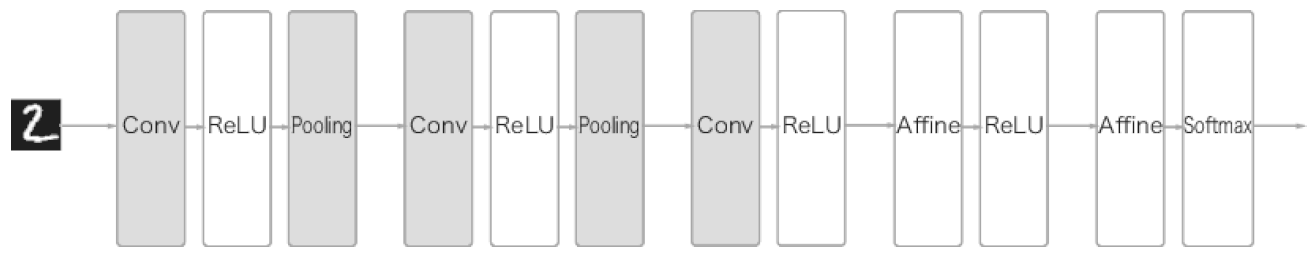

'풀링 계층'은 생략하기도 함

### 7.2 합성곱 계층

**완전연결 계층 (fully-connected)** 에서는 데이터의 형상이 무시되는 반면에,

**합성곱 계층**에서는 형상을 유지한다.

- CNN에서는 합성곱 계층의 입출력 데이터를 **특징 맵** 이라고 한다.

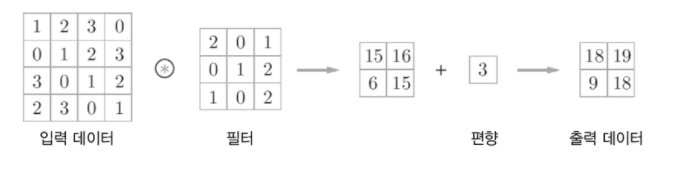

위 그림에서는 입력과 필터에서 대응하는 원소끼리 곱한 후 그 총합을 구함 --> '단일 곱셈-누산 (FMA)

*편향은 필터를 거친 후 더해진다.

- **패딩** :

 출력 크기를 조정할 목적으로 입력데이터 주변을 특정 값으로 채우는 작업

 패딩을 추가할수록 출력 크기가 커진다

- **스트라이드** :

 필터를 적용하는 위치의 간격

 스트라이드를 키우면 출력 크기가 작아진다.

입력크기: $(H,W)$ , 필터크기: $(FH,FW)$ , 패딩: $P$ , 스트라이드: $S$ 일 때의 출력크기: $(OH,OW)$

$OH = \frac{H+2P-FH}{S}+1$

$OW = \frac{W+2P-FW}{S}+1$

이 식이 정수로 나눠떨어지는 값이어야 한다. ( 반올림하는 등 )

- 3차원의 합성곱 연산에서는 입력데이터의 채널 수와 필터의 채널 수가 같아야 한다.

### 7.3 풀링 계층

- **풀링** :

 세로, 가로 방향의 공간을 줄이는 연산

 - 최대 풀링 : 대상 윈도우에서 최댓값을 취하는 방식

 보통, 풀링의 윈도우 크기와 스트라이드는 같은 값으로 설정한다.

풀링 계층의 특징 :

1. 학습해야 할 매개변수가 없다.

2. 채널 수가 변하지 않는다.

3. 입력의 변화에 영향을 적게 받는다. (강건하다)

### 7.4 합성곱 / 풀링 계층 구현하기

In [57]:
# 무작위로 데이터 생성

x = np.random.rand(10,1,28,28)  # 높이 28, 너비 28, 채널 1개인 데이터 10개
print(x.shape)

(10, 1, 28, 28)


In [55]:
print(x[0].shape)
print(x[1].shape)

()
()


In [59]:
print(x[0,0].shape)  # 첫 번째 데이터의 첫 채널의 공간데이터

(28, 28)


넘파이에서는 원소에 접근할 때 for문을 사용하지 않는 것이 바람직하다.

- im2col 함수를 이용하여 구현하자. (image_to_column) : 다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).

 컴퓨터는 큰 행렬을 묶어서 계산하는 데 탁월하기 때문

필터를 세로로 1열로 전개, 필터에 곱해질 윈도우는 가로로 전개하고 행렬 곱을 계산한 후, 마지막으로 출력 데이터를 reshape한다.

    im2col(input_data, filter_h, filter_w, stride=1, pad=0)
    
    input_data : 입력 데이터 (데이터 수, 채널 수, 높이 , 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비


In [44]:
path = "/content/drive/MyDrive/밑바닥부터시작하는딥러닝/deep-learning-from-scratch-master"
os.chdir(path)
sys.path.append(os.chdir)

In [45]:
from common.util import im2col

x1 = np.random.rand(1,3,7,7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

x2 = np.random.rand(10,3,7,7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


In [46]:
# im2col함수로 합성곱 계층 구현하기

class Convolution(object):
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W            # 필터 (가중치)
        self.b = b            # 편향
        self.stride = stride  # 스트라이드
        self.pad = pad        # 패딩
    
    def forward(self, x):
        FN, C, FH, FW = self.W.shape  # 필터개수, 채널 수, 필터높이, 필터너비
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)  # 출력 높이
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)  # 출력 너비

        col = im2col(x, FH, FW, self.stride, self.pad)  # 입력데이터 2차원 배열로 변환
        col_W = self.W.reshape(FN, -1).T    # 필터 전개 --> 1열로 세로정렬
        #col_W = self.W.reshape(-1, FN) <-- 이렇게 해도 됨
 
        out = np.dot(col, col_W) + self.b   # 입력데이터 @ 필터 + 편향

        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)  # 출력 데이터를 적절한 형상으로 변환
        # transpose() : 축 순서를 바꿔주는 함수

        return out

In [47]:
# im2col함수로 풀링 계층 구현하기

class Pooling(object):
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
    
    def forward(self, x):
        N, C ,H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (H - self.pool_w) / self.stride)

        # 전개 (1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        # 최댓값 (2)
        out = np.max(col, axis=1)

        # 성형 (3)
        out = out.reshape(N, out_h, out_w, C).transpose(0,3,1,2)

        return out

In [48]:
stride=2
pad=0
pool_h = pool_w = 2

a = np.array([[[[1,2,3,0],    # 채널1
                [0,1,2,4],
                [1,0,4,2],
                [3,2,0,1]],
               
               [[3,0,6,5],    # 채널1
                [4,2,4,3],
                [3,0,1,0],
                [2,3,3,1]],
               
               [[4,2,1,2],    # 채널1
                [0,1,0,4],
                [3,0,6,2],
                [4,2,4,5]]]])
c = im2col(a, pool_h, pool_w, stride, pad)
print(c)
print(c.shape)
c = c.reshape(-1, pool_h * pool_w)
print(c)
print(c.shape)
out=np.max(c, axis=1)
print(out)
print(out.shape)

[[1. 2. 0. 1. 3. 0. 4. 2. 4. 2. 0. 1.]
 [3. 0. 2. 4. 6. 5. 4. 3. 1. 2. 0. 4.]
 [1. 0. 3. 2. 3. 0. 2. 3. 3. 0. 4. 2.]
 [4. 2. 0. 1. 1. 0. 3. 1. 6. 2. 4. 5.]]
(4, 12)
[[1. 2. 0. 1.]
 [3. 0. 4. 2.]
 [4. 2. 0. 1.]
 [3. 0. 2. 4.]
 [6. 5. 4. 3.]
 [1. 2. 0. 4.]
 [1. 0. 3. 2.]
 [3. 0. 2. 3.]
 [3. 0. 4. 2.]
 [4. 2. 0. 1.]
 [1. 0. 3. 1.]
 [6. 2. 4. 5.]]
(12, 4)
[2. 4. 4. 4. 6. 4. 3. 3. 4. 4. 3. 6.]
(12,)


### 7.5 CNN 구현하기

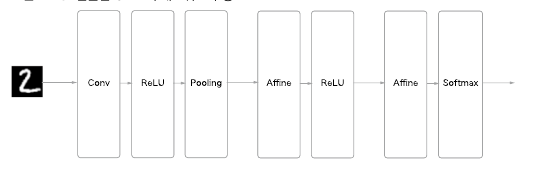

위 그림과 CNN을 구현해보자.

In [49]:
class SimpleConvNet(object):
    def __init__(self, input_dim=(1,28,28),
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 매개변수 초기화
        self.params = {}
        # 합성곱 계층 가중치 매개변수
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        # 1번째 Affine 계층 매개변수
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size,  hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        # 2번째 Affine 계층 매개변수
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        # 가중치들의 형상 맞춰주기 (행렬곱 할때)

        # 계층 생성
        self.layers = {}
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2, pad=0)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        # 별도 변수에 저장
        self.last_layer = SoftMaxWithLoss()   # softmax + cross_entropy Loss function

    
    def predict(self, x):   # 추론 수행
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):   # 손실함수 값 구하기
        y = self.predict(x)
        return self.last_layer.forward(y, t)  # SoftMaxWithLoss 수행
    
    def gradient(self, x, y):   # 기울기 계산 (오차역전파법)
        # 순전파
        self.loss(x,t)

        # 역전파
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()  # 순전파의 계층 순서 뒤집기
        for layer in layers:
            dout = layer.backward(dout)  # 끝에서부터 (소프트맥스 전부터) 역전파하기
        
        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads

train loss:2.2975078313204502
=== epoch:1, train acc:0.097, test acc:0.085 ===
train loss:2.2954194949373505
train loss:2.2909936256265975
train loss:2.2847587846265216
train loss:2.268095619664324
train loss:2.2734752277174453
train loss:2.2564898848697963
train loss:2.230374058365948
train loss:2.213525660154202
train loss:2.1972583626648072
train loss:2.155318497558857
train loss:2.0731285118189784
train loss:2.0613333198592745
train loss:2.0253758352465208
train loss:1.9406280821941522
train loss:1.9267590955514458
train loss:1.856535194977121
train loss:1.863982390016517
train loss:1.691504980966768
train loss:1.6856602298151078
train loss:1.5399576799357653
train loss:1.5206285917807403
train loss:1.4136725146349958
train loss:1.3303557627672313
train loss:1.3090929085494567
train loss:1.1433171125445647
train loss:1.1790990570057418
train loss:1.0892468316439505
train loss:1.035592992584223
train loss:0.8123776785318502
train loss:0.9440786871411224
train loss:0.9525634819587125

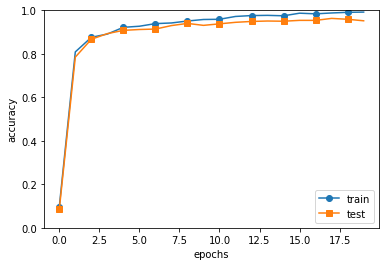

In [50]:
from dataset.mnist import load_mnist
from ch07.simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### 7.6 CNN 시각화하기

1번째 층의 가중치 시각화하기

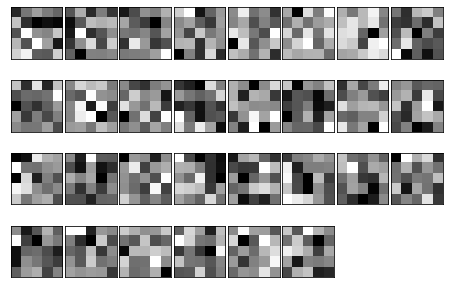

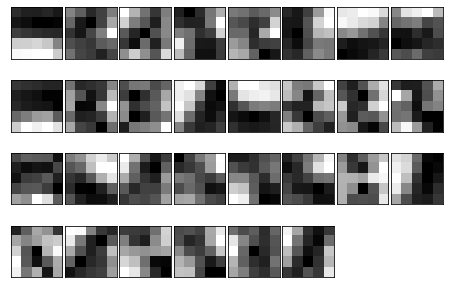

In [51]:
def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])


학습 전 필터는 무작위로 초기화되기 때문에 흑백의 정도에 규칙성이 없다.

반면 학습을 마친 필터는 규칭석을 가지게 된다.

---

계층이 깊어질수록 추출되는 정보 (정확히는 강하게 반응하는 뉴런)는 더 추상화된다.

층이 깊어지면서 뉴런이 반응하는 대상이 '단순한 모양' 에서 '고급정보' 로 변해간다.